# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [215]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import seaborn as sns
from scipy.stats import mode
from inspect import stack
from scipy.integrate import simps, trapz
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## Реализация дерева решений

In [4]:
def subtotals(x):
    X = sorted(list(set(x)))
#     print(X)
    res = np.zeros(len(X)-1)
    for i in range(len(X) - 1):
        res[i] = (X[i] + X[i+1])/2
    return res

In [5]:
def f():
    return len(stack())-25

In [6]:
def gini(x_in):
    x = np.array(x_in)
    labels = list(set(x_in))
    m = len(labels)
    n = len(x)
    Y = dict()
#     for i in range(m):
#         print(x.shape, type(x), x)
#         Y[x[i]] = 0
    Y = {0:0, 1:0}
    for i in range(n):
#         print(Y, type(x), x)
        key = x[i]
#         print(type(float(key)))
        Y[x[i]] += 1/n
    
    S = 0
    for key in Y.keys():
        S += Y[key]*(1 - Y[key])
        
    
    return S
    
def entropy(x_in):
    x = np.array(x_in)
    labels = list(set(x))
    m = len(labels)
    n = len(x)
    Y = {label:0 for label in labels}
    
    for i in range(n):
        Y[x[i]] += 1/n
        
    S = 0
    
    for key in Y.keys():
        S -= Y[key]*np.log2(Y[key])
    return S

def gain(left_y, right_y, criterion):
    y = list(left_y) + list(right_y)
    n_left = len(left_y)
    n_right = len(right_y)
    n_all = n_left + n_right
    return (n_all*criterion(y) - n_right*criterion(right_y) - n_left*criterion(left_y))/n_all

In [7]:
class DecisionTreeLeaf:
    def __init__(self, y):
#         self.mode = mode(y)[0][0]
        self.N = len(y)
        self.set = list(set(y))
        self.y = list(y)
#         raise NotImplementedError()

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
#         raise NotImplementedError()

In [183]:
class DecisionTreeClassifier:

    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        else:
            raise NotImplementedError()
    def build(self, X, y):
        cur_rec = f()
        
        min_IG = -np.inf
        test = False
        res_column = X.columns[1]
        res_threshold = np.inf
        for column in X.columns:
            X_temp = X[column]
            if len(set(X_temp)) > 300:
                thresholds = subtotals(np.array(X_temp))[::len(X_temp)//10]
            else:
                thresholds = sorted(list(set(X_temp)))
            for threshold in thresholds:
                left = y[X_temp < threshold]
                right = y[X_temp >= threshold]
                if len(left) <= self.min_samples_leaf or len(right) <= self.min_samples_leaf:
                    continue
                IG = gain(left, right, self.criterion)
                if IG > min_IG: 
                    test = True
                    res_column = column
                    min_IG = IG
                    res_threshold = threshold
        
        yl = y[X[res_column] < res_threshold]
        yr = y[X[res_column] >= res_threshold]
        Xl = X[X[res_column] < res_threshold].drop(res_column, axis=1)
        Xr = X[X[res_column] >= res_threshold].drop(res_column, axis=1)
        if self.max_depth is None:
            key = False
        elif cur_rec < self.max_depth:
            key = False
        else:
            key = True
            

        if (key) or len(list(X.columns))<=1 or X.empty or res_threshold == np.inf:
            return DecisionTreeLeaf(y)
        else:
            return DecisionTreeNode(res_column, res_threshold,
                                    self.build(Xl, yl),
                                    self.build(Xr, yr))

    def fit(self, X, y):
        self.root = self.build(X, y)

    def search(self, x, Node):
        if type(Node) is DecisionTreeLeaf:
            res = dict()
            for key in Node.set:
                res[key] = Node.y.count(key)/Node.N
            return res
        elif type(Node) is DecisionTreeNode:
            if x[Node.split_dim] < Node.split_value:
                return self.search(x, Node.left)
            elif x[Node.split_dim] >= Node.split_value:
                return self.search(x, Node.right)
        else:
            raise NotImplementedError()
        
    def predict_proba(self, X_in):
        X = X_in#.drop('Id', axis=1)
#         IDs = X_in.Id
        pred = []
        N = len(X)
        for i in range(N):
            x = X.iloc[i]
            pred += [self.search(x, self.root)]
        
        return pred

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.array([max(p.keys(), key=lambda k: p[k]) for p in proba])

In [9]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

In [35]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
#     plt.tight_layout()
    plt.show()

In [90]:
from sklearn.metrics import roc_curve, auc
def roc(proba):
    res = []
    for i in range(len(proba)):
        try:
            res += [proba[i][1]]
        except KeyError:
            res += [0]
    return np.array(res)
def AUC(y_test, proba):
    y_pred = roc(proba)
    tpr,fpr,_ = roc_curve(y_test, y_pred)
    return auc(tpr, fpr)

[{0: 0.7674418604651163, 1: 0.23255813953488372}, {0: 1.0}, {0: 0.06451612903225806, 1: 0.9354838709677419}, {0: 0.20833333333333334, 1: 0.7916666666666666}, {0: 0.9555555555555556, 1: 0.044444444444444446}, {0: 0.6097560975609756, 1: 0.3902439024390244}, {0: 0.7674418604651163, 1: 0.23255813953488372}, {0: 1.0}, {1: 1.0}, {0: 1.0}, {1: 1.0}, {0: 0.20833333333333334, 1: 0.7916666666666666}, {0: 0.9032258064516129, 1: 0.0967741935483871}, {0: 0.7741935483870968, 1: 0.22580645161290322}, {0: 0.7741935483870968, 1: 0.22580645161290322}, {0: 0.7674418604651163, 1: 0.23255813953488372}, {0: 0.20833333333333334, 1: 0.7916666666666666}, {0: 0.7674418604651163, 1: 0.23255813953488372}, {0: 0.9032258064516129, 1: 0.0967741935483871}, {0: 0.7674418604651163, 1: 0.23255813953488372}, {1: 1.0}, {0: 0.20833333333333334, 1: 0.7916666666666666}, {0: 0.6097560975609756, 1: 0.3902439024390244}, {0: 0.06451612903225806, 1: 0.9354838709677419}, {0: 0.20833333333333334, 1: 0.7916666666666666}, {0: 0.77419

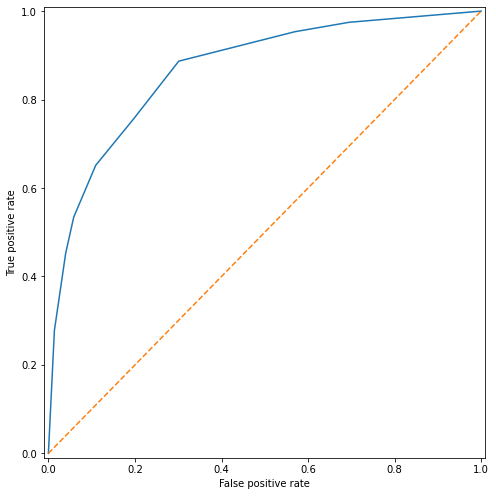

In [379]:
all_X = pd.read_csv('x_spam_train.csv')
all_y = pd.read_csv('y_spam_train.csv')
coef = 0.1
X_train, y_train = all_X.iloc[:round(len(all_X)*coef)], all_y['Expected'].iloc[:round(len(all_X)*coef)]
X_test, y_test = all_X.iloc[round(len(all_X)*coef):], all_y['Expected'].iloc[round(len(all_X)*coef):]#YOUR_CODE
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train.drop('Id', axis=1), y_train)
y_pred = tree.predict(X_test)

# print(AUC(y_test, tree.predict_proba(X_test)))
print(tree.predict_proba(X_test))
plot_roc_curve(y_test, tree.predict_proba(X_test))

In [134]:
X_train.sample(5, axis=1)

,41,24,26,40,10
0,2.38,0.0,0.0,0.0,0.00
1,0.00,0.0,0.0,0.0,0.00
2,0.00,0.0,0.0,0.0,0.00
3,0.00,0.0,0.0,0.0,0.00
4,0.00,0.0,0.0,0.0,0.00
...,...,...,...,...,...
363,0.00,0.0,0.0,0.0,0.05
364,0.00,0.0,0.0,0.0,0.00
365,0.00,0.0,0.0,0.0,0.00
366,0.00,0.0,0.0,0.0,0.00


Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [463]:
class RandomForestClassifier:

    def __init__(self,
                 criterion="gini",
                 max_depth=5,
                 min_samples_leaf=30,
                 max_features="auto",
                 n_estimators=10):

        self.crit = criterion
        self.max_d = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.forest = [
            DecisionTreeClassifier(criterion=criterion,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf)
            for _ in range(n_estimators)
        ]
        
        self.cols = []

        if max_features == 'auto' or max_features == 'sqrt':
            self.max_features = 'sqrt'
        elif max_features == 'log2':
            self.max_features = 'log2'
        elif type(max_features) is int:
            self.max_features = max_features
        else:
            raise NotImplementedError('Неверное количество признаков')

    def fit(self, X, y, n_sample = 300):
        if self.max_features == 'sqrt':
            self.sampling = round(np.sqrt(X.shape[1]))
        elif self.max_features == 'log2':
            self.sampling = round(np.log2(X.shape[1]))
        elif type(self.max_features) is int:
            self.sampling = self.max_features
        else:
            raise NotImplementedError('Неверное количество признаков')
        
        self.set = set()
        for label in y:
            self.set.add(label)
        self.set = list(self.set)
        
        temp = pd.concat((X,y), axis = 1)
        
        sample = temp.sample(n_sample, replace=True)
        
        X_in = sample.drop(['Expected'], axis=1)
        y_in = sample['Expected']
        
        for i in range(len(self.forest)):
            X_temp = X_in.sample(self.sampling, axis=1)
            self.cols += [X_in.columns]
#             print(X_temp)
            self.forest[i].fit(X_temp, y_in)

    def predict(self, X):
        proba = []
        for i in range(len(self.forest)):
#             print(self.cols[i])
            X_temp = X[self.cols[i]]
            proba += [self.forest[i].predict(X_temp)]
            
        return np.transpose(mode(np.array(proba))[0])
    
    def predict_proba(self, X):
        proba = []
        for i in range(len(self.forest)):
#             print(self.cols[i])
            X_temp = X[self.cols[i]]
            proba += [self.forest[i].predict(X_temp)]
            
        proba = np.array(proba).T
        result = []
        
        for i in range(len(X)):
            result += [dict()]
            for label in range(max(self.set)+1):
                result[i][label] = 0
            
        for i in range(len(X)):
            temp = proba[i,:]
            for key in result[i].keys():
#                 print(key, np.sum(temp == key)/len(self.forest))
                result[i][key] = np.sum(temp == key)/len(self.forest)
#             print(result[i])
#         print(result)    
        return result

(1472, 1) (1472,)
0.747089947089947
0.9490134754237616


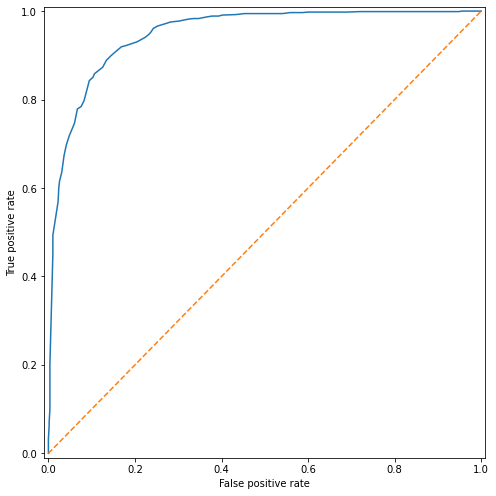

In [464]:
all_X = pd.read_csv('x_spam_train.csv')
all_y = pd.read_csv('y_spam_train.csv')
coef = 0.6
X_train, y_train = all_X.iloc[:round(len(all_X)*coef)], all_y['Expected'].iloc[:round(len(all_X)*coef)]
X_test, y_test = all_X.iloc[round(len(all_X)*coef):], all_y['Expected'].iloc[round(len(all_X)*coef):]#

forest = RandomForestClassifier(max_features='sqrt', n_estimators=100, max_depth=2, min_samples_leaf=30)
forest.fit(X_train.drop('Id', axis=1), y_train, n_sample=250)
test = forest.predict_proba(X_test.drop('Id', axis=1))
res = forest.predict(X_test)
# print(test)
print(res.shape, y_test.shape)
print(f1_score(y_test, res))
print(AUC(y_test, test))
plot_roc_curve(y_test, test)

### 
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [220]:
all_X = pd.read_csv('x_spam_train.csv')
all_y = pd.read_csv('y_spam_train.csv')

In [465]:
depths = [2, 3, 5, 7, 10]
n_trees = [5, 10, 20, 30, 50, 100]

In [466]:
N = len(all_X)
n_splits = 5
splits = [(i*N//n_splits, (i+1)*N//n_splits) for i in range(n_splits)] 
splits

[(0, 736), (736, 1472), (1472, 2208), (2208, 2944), (2944, 3680)]

1-ая итерация из 150
2-ая итерация из 150
3-ая итерация из 150
4-ая итерация из 150
5-ая итерация из 150
6-ая итерация из 150
7-ая итерация из 150
8-ая итерация из 150
9-ая итерация из 150
10-ая итерация из 150
11-ая итерация из 150
12-ая итерация из 150
13-ая итерация из 150
14-ая итерация из 150
15-ая итерация из 150
16-ая итерация из 150
17-ая итерация из 150
18-ая итерация из 150
19-ая итерация из 150
20-ая итерация из 150
21-ая итерация из 150
22-ая итерация из 150
23-ая итерация из 150
24-ая итерация из 150
25-ая итерация из 150
26-ая итерация из 150
27-ая итерация из 150
28-ая итерация из 150
29-ая итерация из 150
30-ая итерация из 150
31-ая итерация из 150
32-ая итерация из 150
33-ая итерация из 150
34-ая итерация из 150
35-ая итерация из 150
36-ая итерация из 150
37-ая итерация из 150
38-ая итерация из 150
39-ая итерация из 150
40-ая итерация из 150
41-ая итерация из 150
42-ая итерация из 150
43-ая итерация из 150
44-ая итерация из 150
45-ая итерация из 150
46-ая итерация из 1

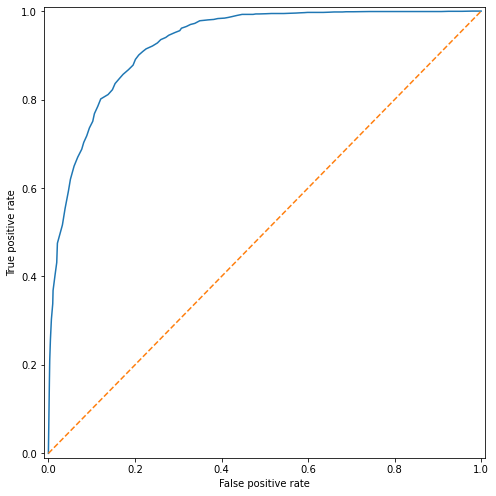

In [468]:
max_AUC = -np.inf
best_depth = 0
best_n = 0
best_proba = None
best_y = None
all_N = len(depths)*len(n_trees)*n_splits
it = 0
for depth in depths:
    for n in n_trees:
        AUC_temp = 0
        for split in splits:
            print(f'{it+1}-ая итерация из {all_N}')
            it += 1
            X_test = all_X.iloc[split[0]:split[1]]
            X_train = pd.concat((all_X.iloc[split[1]:], all_X.iloc[:split[0]]))
            y_test = all_y['Expected'].iloc[split[0]:split[1]]
            y_train = pd.concat((all_y['Expected'].iloc[split[1]:],
                                 all_y['Expected'].iloc[:split[0]]))

            forest = RandomForestClassifier(criterion='gini',
                                            max_depth=depth,
                                            min_samples_leaf=30,
                                            n_estimators=n)
            
#             print(X_train.columns)
            
            forest.fit(X_train.drop('Id', axis=1), y_train, n_sample=150)
            proba = forest.predict_proba(X_test.drop('Id', axis=1))
            
            AUC_temp += AUC(y_test, proba)/n_splits
        
        if AUC_temp > max_AUC:
#             print(AUC_temp)
            max_AUC = AUC_temp
            best_depth = depth
            best_n = n


Лучшая глубина дерева: 5
Лучшее количество деревьев: 100
AUC = 0.9381074256074255
Accuracy = 0.8432971014492754


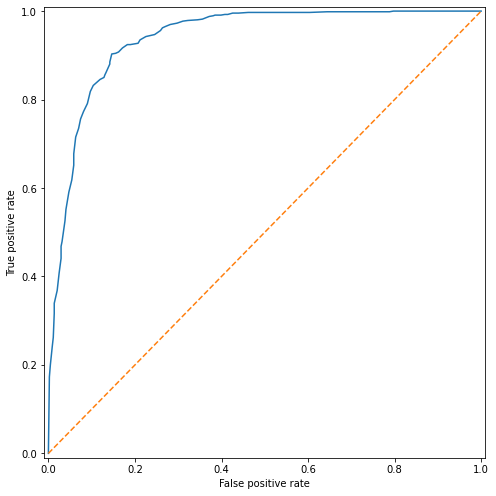

In [470]:
print(f'Лучшая глубина дерева: {best_depth}')
print(f'Лучшее количество деревьев: {best_n}')
forest = RandomForestClassifier(criterion='gini',
                                max_depth=best_depth,
                                min_samples_leaf=30,
                                n_estimators=best_n)

coef = 0.7
X_train, y_train = all_X.iloc[:round(len(all_X)*coef)], all_y['Expected'].iloc[:round(len(all_X)*coef)]
X_test, y_test = all_X.iloc[round(len(all_X)*coef):], all_y['Expected'].iloc[round(len(all_X)*coef):]#

forest.fit(X_train.drop('Id', axis=1), y_train, n_sample=300)
proba = forest.predict_proba(X_test.drop('Id', axis=1))
res = forest.predict(X_test)

res_AUC = AUC(y_test, proba)

print(f'AUC = {res_AUC}')
print(f'Accuracy = {accuracy_score(y_test, res)}')
plot_roc_curve(y_test, proba)

Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [447]:
forest = RandomForestClassifier(criterion='gini',
                                max_depth=best_depth,
                                min_samples_leaf=30,
                                n_estimators=best_n)

coef = 0.1
X_train, y_train = all_X.iloc[:round(len(all_X)*coef)], all_y['Expected'].iloc[:round(len(all_X)*coef)]
X_test, y_test = all_X.iloc[round(len(all_X)*coef):], all_y['Expected'].iloc[round(len(all_X)*coef):]#

forest.fit(X_train.drop('Id', axis=1), y_train)

In [ ]:
def feature_importance(rfc):
    raise NotImplementedError()

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [ ]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc))

Проверьте, какие признаки важны для датасета spam? (Используйте файлы x_spam_train и y_spam_train)

_Ваш ответ_

1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [ ]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = test["Id"]
submission["Expected"] = #YOUR CODE
submission.to_csv('submission.csv', index=False)

В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов.

In [112]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 900.6 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 3.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.6/173.6 MB 3.8 MB/s eta 0:00:00m eta 0:00:010:00:02


1. Примените модели для нашего датасета.

2. Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

3. Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)).

4. Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [1]:
# YOUR_CODE

_Ваш ответ_